<a href="https://colab.research.google.com/github/fares-mldev/uns-ml2021/blob/main/tp5/ML_TP5_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Tendencias en las preferencias de cerveza
Este conjunto de datos contiene alrededor de 1,5 millones de reseñas de cervezas de BeerAdvocates. 

Su objetivo es caracterizar el conjunto de datos, agrupar cervezas similares y poder recomendar una cerveza, que preguntas podría responder utilizando los datos, por ejemplo: si tuviera que elegir 5 cervezas para recomendar, ¿cuál elegiría? ¿Por qué? ¿Cuáles de los factores (sabor, aroma, apariencia, paladar) son más importantes para determinar la la calidad general de una cerveza? Si por lo general disfruto de las IPA, ¿qué cerveza debo probar?

In [123]:
#@title Requirements
!pip install umap-learn

### Data ingestion and cleaning

In [124]:
#@title Import data
import pandas as pd
beer_reviews_1 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_1.csv")
beer_reviews_2 = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_2.csv")

In [125]:
#@title Data analysis dataset 1
#@markdown There are missing values in profile name and abv

beer_reviews_1.describe()
beer_reviews_1.info()
beer_reviews_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871901 entries, 0 to 871900
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brewery_id          871901 non-null  int64  
 1   brewery_name        871892 non-null  object 
 2   review_time         871901 non-null  int64  
 3   review_overall      871901 non-null  float64
 4   review_aroma        871901 non-null  float64
 5   review_appearance   871901 non-null  float64
 6   review_profilename  871720 non-null  object 
 7   beer_style          871901 non-null  object 
 8   review_palate       871901 non-null  float64
 9   review_taste        871901 non-null  float64
 10  beer_name           871901 non-null  object 
 11  beer_abv            835659 non-null  float64
 12  beer_beerid         871901 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 86.5+ MB


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [126]:
#@title Data analysis dataset 2
#@markdown There are missing values in profile name, brewery name and abv

beer_reviews_2.describe()
beer_reviews_2.info()
beer_reviews_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714713 entries, 0 to 714712
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brewery_id          714713 non-null  int64  
 1   brewery_name        714707 non-null  object 
 2   review_time         714713 non-null  int64  
 3   review_overall      714713 non-null  float64
 4   review_aroma        714713 non-null  float64
 5   review_appearance   714713 non-null  float64
 6   review_profilename  714546 non-null  object 
 7   beer_style          714713 non-null  object 
 8   review_palate       714713 non-null  float64
 9   review_taste        714713 non-null  float64
 10  beer_name           714713 non-null  object 
 11  beer_abv            683170 non-null  float64
 12  beer_beerid         714713 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 70.9+ MB


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,147,Stone Brewing Co.,1283263116,4.0,4.0,4.0,Tilley4,American Barleywine,4.5,4.0,Stone Old Guardian Barley Wine Style Ale 2010,11.1,56068
1,147,Stone Brewing Co.,1283104309,4.0,4.0,4.0,kzoobrew,American Barleywine,4.5,4.0,Stone Old Guardian Barley Wine Style Ale 2010,11.1,56068
2,147,Stone Brewing Co.,1283041969,4.0,4.0,4.0,atsprings,American Barleywine,3.5,4.0,Stone Old Guardian Barley Wine Style Ale 2010,11.1,56068
3,147,Stone Brewing Co.,1282794993,4.5,4.0,3.5,dasenebler,American Barleywine,4.5,4.5,Stone Old Guardian Barley Wine Style Ale 2010,11.1,56068
4,147,Stone Brewing Co.,1282599829,4.0,4.0,4.0,JoEBoBpr,American Barleywine,4.0,4.5,Stone Old Guardian Barley Wine Style Ale 2010,11.1,56068


In [127]:
#@title Merge datasets
#@markdown We merge both datasets

df_raw = pd.concat([ beer_reviews_1,  beer_reviews_2])
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586614 entries, 0 to 714712
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 169.5+ MB


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [128]:
#@title Data Cleaning
import numpy as np
from sklearn.impute import SimpleImputer

#@markdown Classify the features by type and apply different imputing criteria.
#@markdown For the numeric columns we complete missing values with the average.
#@markdown For the rest we simply drop rows with missing value.

# Classify columns into types
date_cols = ['review_time']
num_cols = ['review_overall', 'review_aroma' , 'review_appearance', 'review_palate', 'review_taste' 
            ,'beer_abv'
            ]
id_cols = ['brewery_id', 'beer_beerid' ]
name_cols = ['brewery_name','review_profilename' , 'beer_style', 'beer_name']

# Drop non interesting columns
#drop_cols = ['brewery_name']
#df = df_raw.drop(drop_cols, axis = 1)

# Copy raw dataframe
df = df_raw.copy()

# Handle numeric columns missing values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df[num_cols])
df[num_cols] = imp_mean.transform(df[num_cols]) 

# Handle name columns missing values 
df.dropna(how='any', inplace = True) 

df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586251 entries, 0 to 714712
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586251 non-null  int64  
 1   brewery_name        1586251 non-null  object 
 2   review_time         1586251 non-null  int64  
 3   review_overall      1586251 non-null  float64
 4   review_aroma        1586251 non-null  float64
 5   review_appearance   1586251 non-null  float64
 6   review_profilename  1586251 non-null  object 
 7   beer_style          1586251 non-null  object 
 8   review_palate       1586251 non-null  float64
 9   review_taste        1586251 non-null  float64
 10  beer_name           1586251 non-null  object 
 11  beer_abv            1586251 non-null  float64
 12  beer_beerid         1586251 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 169.4+ MB


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [134]:
#@title Beer list
df_beers = df[['beer_beerid','brewery_id','brewery_name','beer_style','beer_name']].drop_duplicates()
df_beers

,beer_beerid,brewery_id,brewery_name,beer_style,beer_name
0,47986,10325,Vecchio Birraio,Hefeweizen,Sausa Weizen
1,48213,10325,Vecchio Birraio,English Strong Ale,Red Moon
2,48215,10325,Vecchio Birraio,Foreign / Export Stout,Black Horse Black Beer
3,47969,10325,Vecchio Birraio,German Pilsener,Sausa Pils
4,64883,1075,Caldera Brewing Company,American Double / Imperial IPA,Cauldron DIPA
...,...,...,...,...,...
714693,38160,14359,The Defiant Brewing Company,American Porter,Highland Porter
714694,71234,14359,The Defiant Brewing Company,Hefeweizen,Baron Von Weizen
714695,48360,14359,The Defiant Brewing Company,Belgian Strong Pale Ale,Resolution #2
714698,43233,14359,The Defiant Brewing Company,American Double / Imperial IPA,Double IPA


##Strategy

One possible strategy is to group similar reviews together, then apply some metric to rank them, and choose the best ranked cluster. If one is interested in a specific beer category, we could filter first by category (all beer types that include IPA) and then apply clustering on the review scores.

An altenative method can be clustering by beer categories, finding similar names and then choose the best ranked beer on each category. 

in this work we will first caracterize each beer by its review ratings, and then apply clustering to group beers with similar reviews. At the end we apply some scoring criteria to select the cluster with the best reviews.

##Feature engineering

In the first place we need to perform feature engeneering for each beer. One option is to aggregate each review dimension in some way (min, max, mean, median)

In this work we chose to approximate the histogram of each review category with percentiles 5,25,50,75 and 95.

This will generate a rich feature content even after aggregating.

In [205]:
#@title Feature generation
#@markdown Compute percentiles of each review dimension.

# Percentile calculation
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Feature generation
df_feat = df.groupby(by='beer_beerid').agg(({'review_overall': [ percentile(5), percentile(25),percentile(50),percentile(75),percentile(95)],
                                             'review_appearance': [  percentile(5), percentile(25),percentile(50),percentile(75),percentile(95)],
                                             'review_aroma': [  percentile(5), percentile(25),percentile(50),percentile(75),percentile(95)],
                                             'review_palate': [ percentile(5), percentile(25),percentile(50),percentile(75),percentile(95)],
                                             'review_taste': [ percentile(5), percentile(25),percentile(50),percentile(75),percentile(95)],
                                             })) 

# Convert multi-level columns to flat
df_feat.columns = ["_".join(a) for a in df_feat.columns.to_flat_index()]
df_feat

,review_overall_percentile_5,review_overall_percentile_25,review_overall_percentile_50,review_overall_percentile_75,review_overall_percentile_95,review_appearance_percentile_5,review_appearance_percentile_25,review_appearance_percentile_50,review_appearance_percentile_75,review_appearance_percentile_95,review_aroma_percentile_5,review_aroma_percentile_25,review_aroma_percentile_50,review_aroma_percentile_75,review_aroma_percentile_95,review_palate_percentile_5,review_palate_percentile_25,review_palate_percentile_50,review_palate_percentile_75,review_palate_percentile_95,review_taste_percentile_5,review_taste_percentile_25,review_taste_percentile_50,review_taste_percentile_75,review_taste_percentile_95
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,
3,4.0,4.000,4.0,4.25,4.450,3.55,3.75,4.0,4.0,4.000,3.55,3.75,4.00,4.250,4.45,4.0,4.0,4.0,4.25,4.45,4.000,4.000,4.0,4.250,4.45
4,3.0,3.125,3.5,4.00,4.775,2.95,4.00,4.0,4.0,4.775,3.00,3.50,3.75,4.375,4.50,2.5,3.5,4.0,4.00,4.55,2.225,3.125,3.5,3.875,4.55
5,2.5,3.000,3.5,4.00,4.500,2.50,3.00,3.5,4.0,4.000,2.00,3.00,3.00,3.500,4.00,2.0,3.0,3.5,4.00,4.00,2.000,3.000,3.5,4.000,4.00
6,2.5,3.500,4.0,4.00,4.500,3.00,3.50,4.0,4.0,4.500,2.50,3.00,3.50,4.000,4.50,2.5,3.0,3.5,4.00,4.50,2.500,3.500,3.5,4.000,4.50
7,1.5,3.000,3.5,4.00,4.500,2.00,3.00,3.0,3.5,4.000,2.00,3.00,3.00,3.500,4.00,2.0,3.0,3.0,3.50,4.00,1.500,2.500,3.0,3.500,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77313,3.0,3.000,3.0,3.00,3.000,4.00,4.00,4.0,4.0,4.000,3.00,3.00,3.00,3.000,3.00,3.0,3.0,3.0,3.00,3.00,3.000,3.000,3.0,3.000,3.00
77314,3.5,3.500,3.5,3.50,3.500,4.00,4.00,4.0,4.0,4.000,3.50,3.50,3.50,3.500,3.50,3.0,3.0,3.0,3.00,3.00,4.000,4.000,4.0,4.000,4.00
77315,3.5,3.500,3.5,3.50,3.500,3.00,3.00,3.0,3.0,3.000,4.50,4.50,4.50,4.500,4.50,3.0,3.0,3.0,3.00,3.00,3.500,3.500,3.5,3.500,3.50


In [210]:
#@title Scoring function
#@markdown In order to compare two reviews with a single metric, we will apply the harmonic mean of all its features. 

def label_to_rank(X, y, by , agg = 'min'):
  '''
  This function ranks the label according to average rating
  '''
  df = X.copy()
  df['label']=y
  df = df.groupby(by='label').agg({by: [agg] })
  df.columns = ['__'.join(col).strip() for col in df.columns.values]
  df_ranked = df.sort_values(by=by+'__'+agg,ascending = False).reset_index()
  arr_map = np.array(df_ranked['label'])
  dict_map = {label:rank for rank,label in enumerate(arr_map)}
  ranks = [dict_map[key] for key in y ]
  return np.array(ranks)

df_feat['hmean']=stats.hmean(df_feat, axis = 1)
df_feat['hmean']

beer_beerid
3        4.040883
4        3.585834
5        3.144340
6        3.484128
7        2.840653
           ...   
77313    3.157895
77314    3.559322
77315    3.423913
77316    3.500000
77317    3.684211
Name: hmean, Length: 66040, dtype: float64

In [208]:
#@title Subsample data 
#@markdown For performance issues we subsample the data.

#https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

from sklearn.model_selection import train_test_split 
X_train, _ = train_test_split(df_feat, test_size=0.9)
X = X_train

X

,review_overall_percentile_5,review_overall_percentile_25,review_overall_percentile_50,review_overall_percentile_75,review_overall_percentile_95,review_appearance_percentile_5,review_appearance_percentile_25,review_appearance_percentile_50,review_appearance_percentile_75,review_appearance_percentile_95,review_aroma_percentile_5,review_aroma_percentile_25,review_aroma_percentile_50,review_aroma_percentile_75,review_aroma_percentile_95,review_palate_percentile_5,review_palate_percentile_25,review_palate_percentile_50,review_palate_percentile_75,review_palate_percentile_95,review_taste_percentile_5,review_taste_percentile_25,review_taste_percentile_50,review_taste_percentile_75,review_taste_percentile_95,hmean
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,,
7447,2.0,2.5,3.0,3.50,4.50,1.500,2.000,3.00,3.000,4.000,1.175,2.00,2.25,2.50,3.00,1.500,2.500,3.00,3.125,4.325,1.500,2.000,2.50,3.000,4.000,2.391278
56311,4.0,4.0,4.0,4.00,4.00,3.525,3.625,3.75,3.875,3.975,3.050,3.25,3.50,3.75,3.95,3.050,3.250,3.50,3.750,3.950,4.000,4.000,4.00,4.000,4.000,3.721309
18247,4.0,4.0,4.0,4.00,4.00,4.000,4.000,4.00,4.000,4.000,4.000,4.00,4.00,4.00,4.00,4.000,4.000,4.00,4.000,4.000,4.500,4.500,4.50,4.500,4.500,4.090909
75744,2.5,2.5,2.5,2.50,2.50,3.500,3.500,3.50,3.500,3.500,2.500,2.50,2.50,2.50,2.50,3.500,3.500,3.50,3.500,3.500,2.500,2.500,2.50,2.500,2.500,2.822581
74194,4.0,4.0,4.0,4.00,4.00,4.000,4.000,4.00,4.000,4.000,3.500,3.50,3.50,3.50,3.50,3.525,3.625,3.75,3.875,3.975,4.025,4.125,4.25,4.375,4.475,3.880406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2480,2.5,3.0,3.5,4.00,4.50,2.500,3.000,3.50,3.500,4.000,2.500,3.00,3.00,3.50,4.00,2.500,3.000,3.50,3.500,4.000,2.500,3.000,3.50,3.500,4.000,3.222506
69826,4.0,4.0,4.0,4.00,4.00,3.500,3.500,3.50,3.500,3.500,3.500,3.50,3.50,3.50,3.50,3.500,3.500,3.50,3.500,3.500,4.000,4.000,4.00,4.000,4.000,3.684211
54008,4.0,4.0,4.0,4.25,4.45,3.550,3.750,4.00,4.000,4.000,4.000,4.00,4.00,4.00,4.00,3.550,3.750,4.00,4.000,4.000,4.000,4.000,4.00,4.000,4.000,3.964021


##Training

We apply 4 different clustering methods: K-means, Agglomerative, Gaussian mixture and DBSCAN.

In [211]:
#@title Clustering scoring 
#@markdown In order to asess the quality of the clustering result we use three different measures:

#@markdown **Silhouette coefficient**:
#@markdown Calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
#@markdown The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
#@markdown b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
#@markdown The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
#@markdown The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
  
#@markdown **Calinski-Harabasz**: 
#@markdown Also known as the Variance Ratio Criterion.
#@markdown Defined as ratio between the within-cluster dispersion and the between-cluster dispersion.
#@markdown The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
  
#@markdown **Davies-bouldin**:
#@markdown The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#@markdown where similarity is the ratio of within-cluster distances to between-cluster distances. 
#@markdown Thus, clusters which are farther apart and less dispersed will result in a better score.
#@markdown Zero is the lowest possible score. Values closer to zero indicate a better partition.

# Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

def score(X,y):
  '''
  Applies a list of unsupervised scoring metrics to dataset X and labels y
  Returns a dictionary
  '''
  scores = {}

  #The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) 
  #and the mean nearest-cluster distance (b) for each sample. 
  #The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
  #To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
  #The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
  #The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
  scores['sil'] = silhouette_score(X, y, metric='euclidean')
  
  #It is also known as the Variance Ratio Criterion.
  #Defined as ratio between the within-cluster dispersion and the between-cluster dispersion.
  #The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
  scores['cal'] = calinski_harabasz_score(X, y)
  
  #The score is defined as the average similarity measure of each cluster with its most similar cluster, 
  #where similarity is the ratio of within-cluster distances to between-cluster distances. 
  #Thus, clusters which are farther apart and less dispersed will result in a better score.
  #Zero is the lowest possible score. Values closer to zero indicate a better partition.
  scores['db'] = davies_bouldin_score(X, y)

  return scores



In [284]:
#@title Training helper
#@markdown We define some helper functions for the training step.

from sklearn.pipeline import Pipeline 
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone
from sklearn.mixture import GaussianMixture

def get_labels(clf, step = "clust", X = None ):
  '''
  Sets a list of parameters passed as dictionary as attributes of object
  '''
  labels = None

  # Gaussian mixture requires to run predict
  if isinstance(clf[step], GaussianMixture):
    labels = clf.predict(X)
  else: 
    labels = clf[step].labels_
  return labels

def set_params(clf, params):
  '''
  Sets a list of parameters passed as dictionary as attributes of object
  '''
  for key in params:
    step, param = key.split('__')
    setattr(clf[step], param, params[key])

def train_model(clf, X,  params_dict):
  '''
  Trains a set of unsupervised classifiers clf performing grid search over params_list
  Returns:
    model_list: List of trained models
    labels_list: List of training labels
    scores_list: List of training scores
  '''

  params_list = list(ParameterGrid(params_dict))

  # Init results
  model_list = []
  scores_list = []
  labels_list = []

  # Loop over parameter combinations
  for idx, params in enumerate(params_list):

    # Add model to list and get pointer    
    model_list.append(clone(clf))
    model = model_list[-1]

    # Set model parameters
    set_params(model, params)
    
    # Train model
    model.fit(X)

    # Get labels
    y = get_labels( model , step='clust', X=X)

    # Append label to list
    labels_list.append(y)
    
    # score model
    scores = score(X,y)
  
    # Append model to list
    scores_list.append(scores)

  return model_list, scores_list, labels_list, params_list

def show_cluster_content(X, df_beers, labels_list):
  
  result = X.copy()
  result['label'] = label_to_rank(result,labels_list, by='hmean')
  result = result.merge(df_beers, how='inner' ,left_on ='beer_beerid', right_on='beer_beerid')
  result = result[result['label']==0].sort_values(by='hmean', ascending = False)
  return   result[['beer_beerid','brewery_name','beer_style','beer_name','hmean']]

# Define some dictionaries to store the results
model_list = {}
scores_list = {}
labels_list = {}
params_list = {}

In [276]:
#@title Plot helper
#@markdown We define some helper functions for plotting the results

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

def plot_result(X, y, ax, text = '', mapping = 'pca'):

  if mapping == 'pca':
    # Project on two most significative PCA components  
    sca = StandardScaler()
    pca = PCA(n_components=2)
    X_map = pca.fit_transform(sca.fit_transform(X))

  if mapping == 'umap':
    reducer = umap.UMAP(
                        n_neighbors = 100, 
                        #min_dist = 0.05
                        )
    X_map = reducer.fit_transform(X)

  # Scatterplot
  scatter = ax.scatter(X_map[:,0],X_map[:,1], c = y , cmap = 'rainbow', alpha=0.5)

  # produce a legend with the unique colors from the scatter
  legend = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="cluster")
  ax.add_artist(legend)
  
  # set plot title
  ax.set_title(text)

def plot_results(X,labels_list,params_list, title):
  # Plot results
  fig, axes = plt.subplots(3,3)
  fig.set_size_inches(15,15)
  fig.suptitle(title + ' - cluster visualization',fontsize=20, y=0.98)
  for idx, ax in enumerate(axes.reshape(-1)):
    plot_result(X, label_to_rank(X,labels_list[idx], by = 'hmean'), ax, params_list[idx])

def plot_clustering_scores(scores_list, params_list, title, param_name):
  scores_df = pd.DataFrame.from_dict(scores_list[key])
  params_df = pd.DataFrame.from_dict(params_list[key])
  params_df = params_df.join(scores_df) 

  fig, axs = plt.subplots(1,3)
  fig.set_size_inches(15,6)
  fig.suptitle(title+' - clustering scorings', fontsize=20)
  #params_df.sort_values(by='sil', ascending= False)
  axs[0].plot(params_df[param_name],params_df[['sil']])
  axs[0].set_title('Silouette Coefficient')
  axs[1].plot(params_df[param_name],params_df[['cal']])
  axs[1].set_title('Calinski-Harabasz coefficient')
  axs[2].plot(params_df[param_name],params_df[['db']])
  axs[2].set_title('Davies-bouldin coefficient')

In [287]:
#@title K-Means clustering: train

key = 'kmeans'

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Model
sca = StandardScaler()
pca = PCA()
clust = KMeans()
clf = Pipeline(steps=[('sca', sca),
                      ('pca', pca),
                      ('clust', clust)])

# Hyperparameters
params_dict = {
         'clust__n_clusters': [20,30,40,50,60,70,80,100,120],
         }

# Train model 
model_list[key], scores_list[key], labels_list[key], params_list[key] = train_model(clf, X, params_dict)


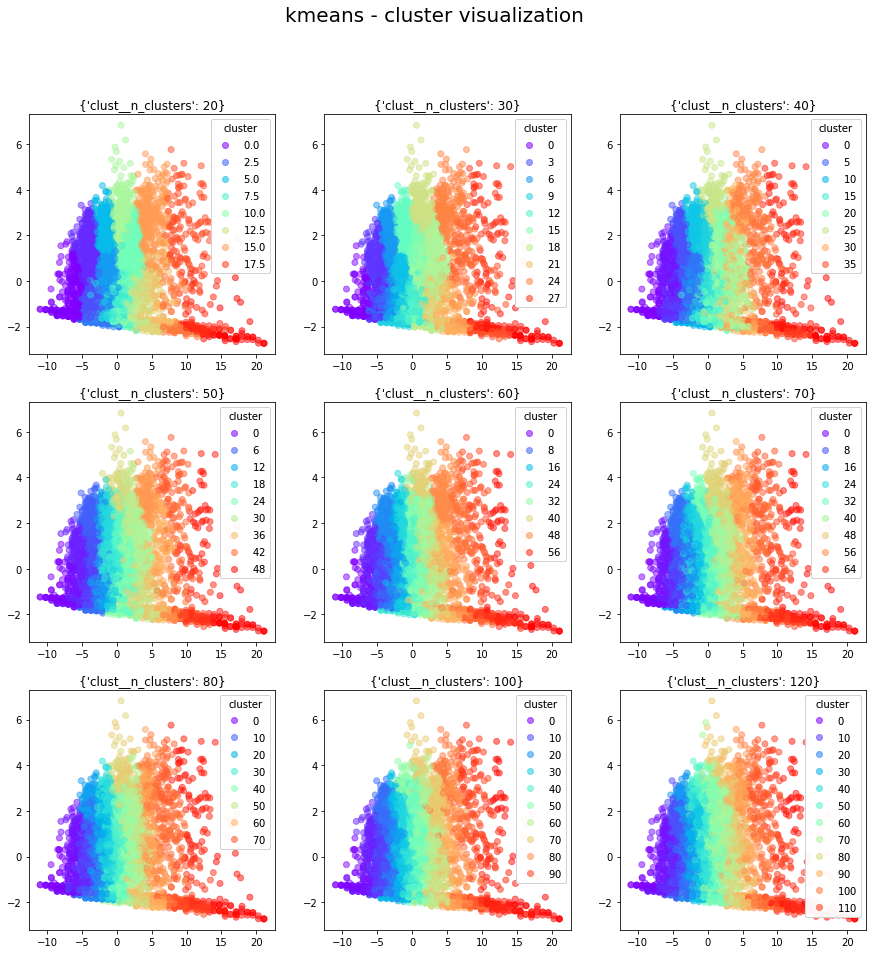

In [288]:
#@title K-Means clustering: plot clusters
#@markdown The clusters on the left seem to have better overall score.
#@markdown Notably, on very high or very low tere seems to be lower dispersion,
#@markdown While on the intermediate ratings, there is more variation on rating dimensions.

key = 'kmeans'
plot_results(X,labels_list[key],params_list[key], key)

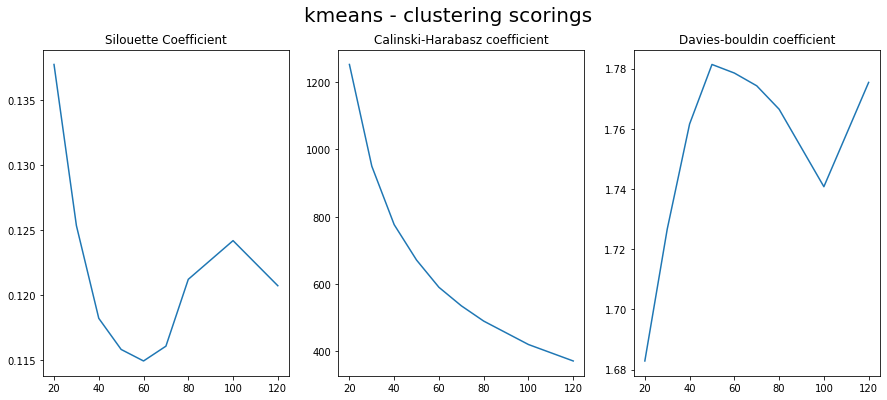

In [289]:
#@title K-Means clustering: plot cluster scoring
#@markdown There seems to be an optimal point around 50 or 60 clusters.
#@markdown The calinski-harabasz coefficient does not have an clear inflection point, but the maximum curvature seems to be consistent with the other scores.

key = 'kmeans'
plot_clustering_scores(scores_list, params_list, key, 'clust__n_clusters')

In [298]:
#@title K-means clustering: show best cluster content
#@markdown The top 5 scores seem to be good (high scores). 
#@markdown The worst score is pretty good also, showing that the algorithm made a decent job grouping similar ratings.

key = 'kmeans'
idx = 4
show_cluster_content(X, df_beers,labels_list[key][idx])

,beer_beerid,brewery_name,beer_style,beer_name,hmean
3014,3614,Empire Brewing Company,Doppelbock,Empire Doppelbock,5.000000
1793,50133,Howe Sound Inn & Brewing Company,Scottish Ale,Goodes Highland Scotch Ale,5.000000
4815,67617,Thr3e Wise Men,Irish Dry Stout,Saint Slater Irish Stout,4.891304
3019,72678,Big Buck Brewery & Steakhouse #1,American Double / Imperial Stout,Campfire Joe,4.891304
1854,76906,508 Gastrobrewery,Russian Imperial Stout,508 Montezuma Imperial Stout,4.891304
298,35488,Wiltse's Brew Pub and Family Restaurant,American Stout,Wiltse's Blue Ox Stout,4.891304
1535,52218,Right Brain Brewery,American Stout,Chocolate Cinnamon Cream Stout,4.793422
1571,35787,Goose Island Beer Co.,American Double / Imperial Stout,Coffee Stout,4.788693
190,27824,Bristol Brewing Company,Schwarzbier,Schwarzbier,4.787234
5709,67795,W. J. King & Co. Brewers,English Bitter,Five Generations,4.787234


In [294]:
#@title Agglomerative clustering: train

key = 'agglomerative'

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Model
sca = StandardScaler()
pca = PCA()
clust = AgglomerativeClustering()
clf = Pipeline(steps=[('sca', sca),
                      ('pca', pca),
                      ('clust', clust)])

# Hyperparameters
params_dict = {
         'clust__n_clusters': [10,20,30,40,50,60,70,80,90],
         }

# Train model 
model_list[key], scores_list[key], labels_list[key], params_list[key] = train_model(clf, X, params_dict)


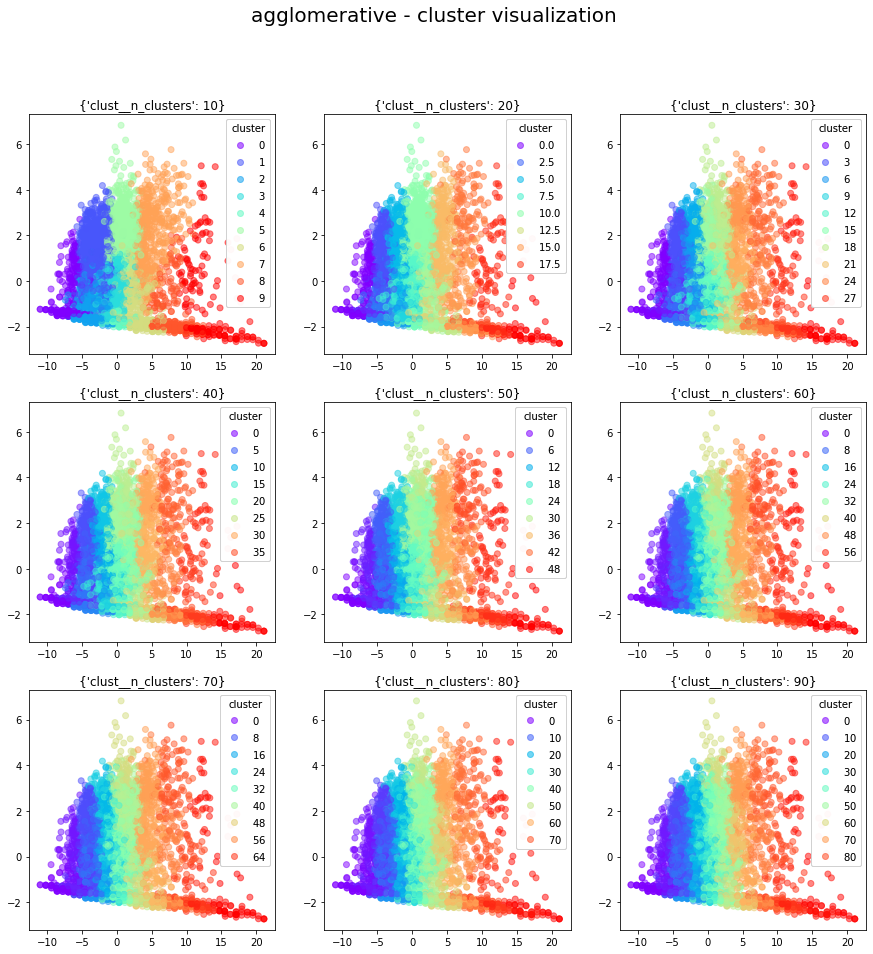

In [295]:
#@title Agglomerative clustering: plot clusters

key = 'agglomerative'
plot_results(X,labels_list[key],params_list[key], key)

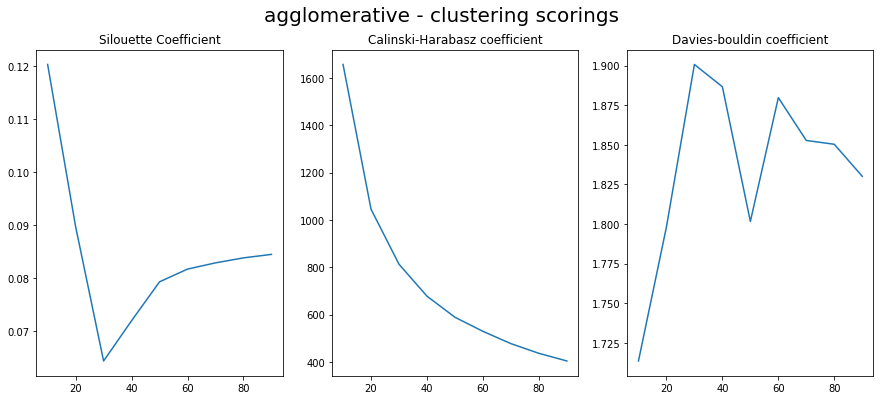

In [296]:
#@title Agglomerative clustering: plot cluster scoring
#@markdown There is a minimum in silouette at 30 clusters, while davies-bouldin gives a local minima at cluster size 50.
#@markdown The calinski-harabasz coefficient does not have an clear inflection point, but the maximum curvature seems to be between the other scores.

key = 'agglomerative'
plot_clustering_scores(scores_list, params_list, key, 'clust__n_clusters')

In [315]:
#@title Agglomerative clustering: show best cluster content
#@markdown The top 5 scores seem to be good, as in k-means. 
#@markdown The worst score is rather good, but not as good as in k-means.

key = 'agglomerative'
idx = 2
show_cluster_content(X, df_beers,labels_list[key][idx])

,beer_beerid,brewery_name,beer_style,beer_name,hmean
3014,3614,Empire Brewing Company,Doppelbock,Empire Doppelbock,5.000000
1793,50133,Howe Sound Inn & Brewing Company,Scottish Ale,Goodes Highland Scotch Ale,5.000000
4815,67617,Thr3e Wise Men,Irish Dry Stout,Saint Slater Irish Stout,4.891304
3019,72678,Big Buck Brewery & Steakhouse #1,American Double / Imperial Stout,Campfire Joe,4.891304
1854,76906,508 Gastrobrewery,Russian Imperial Stout,508 Montezuma Imperial Stout,4.891304
...,...,...,...,...,...
2677,44443,Zero Gravity Craft Brewery / American Flatbread,Old Ale,(Extra) Old Ale,4.250629
5644,12536,McAuslan Brewing,English Barleywine,McAuslan Vintage Ale,4.229690
702,48570,Ballast Point Brewing Company,American IPA,Sculpin (Double Dry Hopped),4.227962
2989,37384,BrewPub København,American IPA,Atlantic IPA,4.147379


In [375]:
#@title Gaussian mixture clustering: train

key = 'gaussian'

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Model
sca = StandardScaler()
pca = PCA()
clust = GaussianMixture()
clf = Pipeline(steps=[('sca', sca),
                      ('pca', pca),
                      ('clust', clust)])

# Hyperparameters
params_dict = {
         'clust__n_components': [10,20,30,40,50,60,70,80,90],
         }

# Train model 
model_list[key], scores_list[key], labels_list[key], params_list[key] = train_model(clf, X, params_dict)


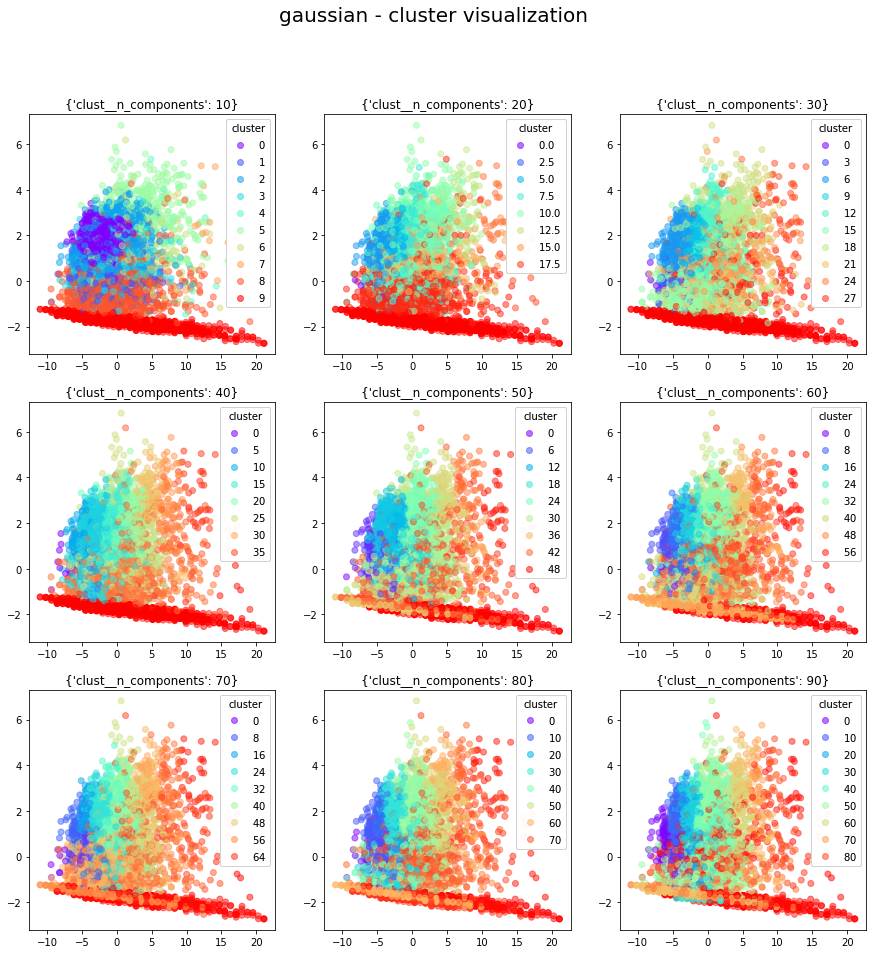

In [380]:
#@title Gaussian mixture clustering: plot clusters
#@markdown The gaussian mixture seems to be capturing a different pattern.
#@markdown Both best and worst results is clustered together in the same group.
#@markdown Probably it is focusing in clustering together consistent ratings, rather than good or bad ratings.

key = 'gaussian'
plot_results(X,labels_list[key],params_list[key], key)

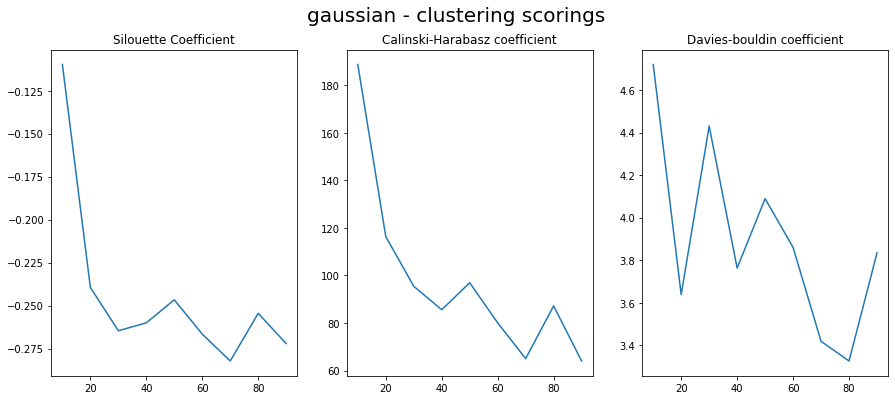

In [382]:
#@title Gaussian mixture clustering: plot cluster scoring
#@markdown There is a minimum in silouette at 70 clusters, being consistent with the davies-bouldin criteria. 
#@markdown The calinski-harabasz coefficient seems to have an inflection point at ~40 clusters, but it is very noisy and it is difficult to extract a conclusion.

key = 'gaussian'
plot_clustering_scores(scores_list, params_list, key, 'clust__n_components')

In [386]:
#@title Gaussian mixture clustering: show best cluster content
#@markdown The top scores on the best cluster seem to be lower than the ones obtained with previous methods.

key = 'gaussian'
idx = 8
show_cluster_content(X, df_beers,labels_list[key][idx])

,beer_beerid,brewery_name,beer_style,beer_name,hmean
5269,58481,Harpoon Brewery,American Double / Imperial IPA,Harpoon Oak Aged Imperial IPA,4.649249
3015,47157,Flossmoor Station Restaurant & Brewery,Belgian IPA,Organic Woody,4.625269
6191,35549,Ellicottville Brewing Co.,Oatmeal Stout,Black Jack,4.529072
5558,65368,Nail Brewing Australia Pty Ltd,Russian Imperial Stout,Clout Stout,4.512887
5832,50253,Cigar City Brewing,English Dark Mild Ale,Chaveta India Dark Mild - Cedar Aged (Humidor ...,4.414517
319,57570,Eskilstuna Ölkultur,Czech Pilsener,Fröslunda Tjeckisk Pilsner,4.229924


In [387]:
#@title DBSCAN clustering: train

key = 'dbscan'

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Training data
X = X_train

# Model
sca = StandardScaler()
pca = PCA()
clust = DBSCAN()
clf = Pipeline(steps=[('sca', sca),
                      ('pca', pca),
                      ('clust', clust)])

# Hyperparameters
params_dict = {
          'clust__eps': [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9],
          'clust__min_samples': [2],
         }

# Train model 
model_list[key], scores_list[key], labels_list[key], params_list[key] = train_model(clf, X, params_dict)


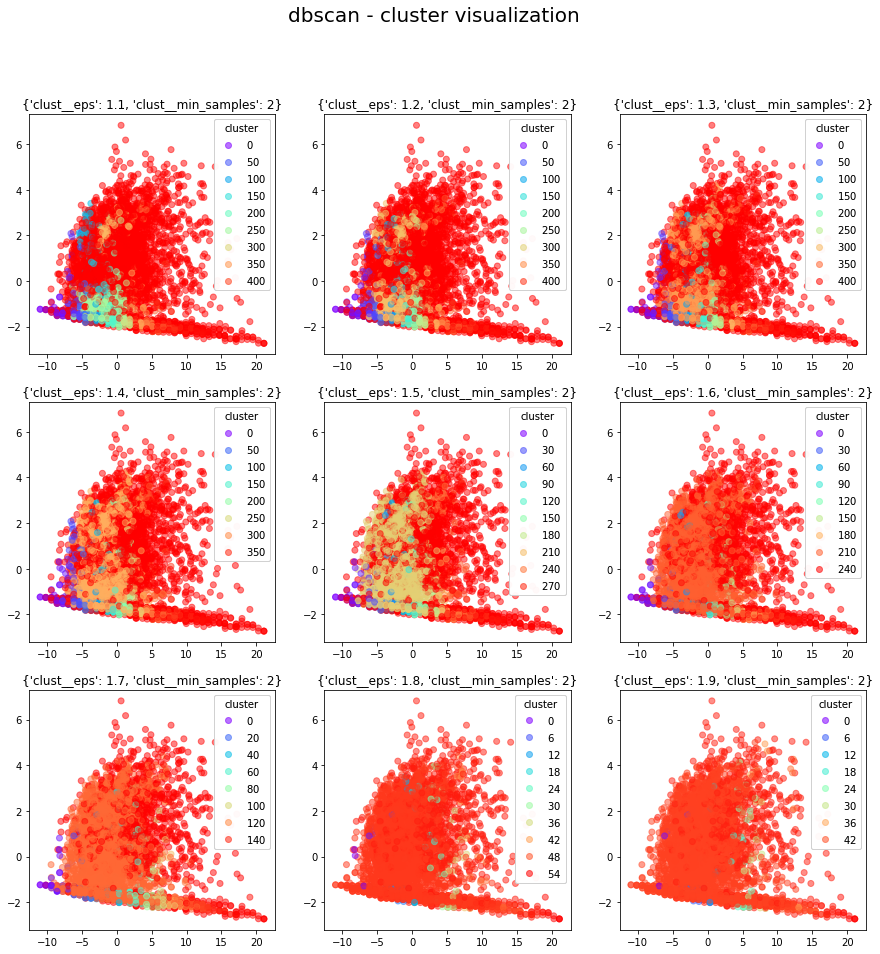

In [388]:
#@title DBSCAN clustering: plot clusters
#@markdown Cluster sizes are computed automatically in this method.

key = 'dbscan'
plot_results(X,labels_list[key],params_list[key], key)

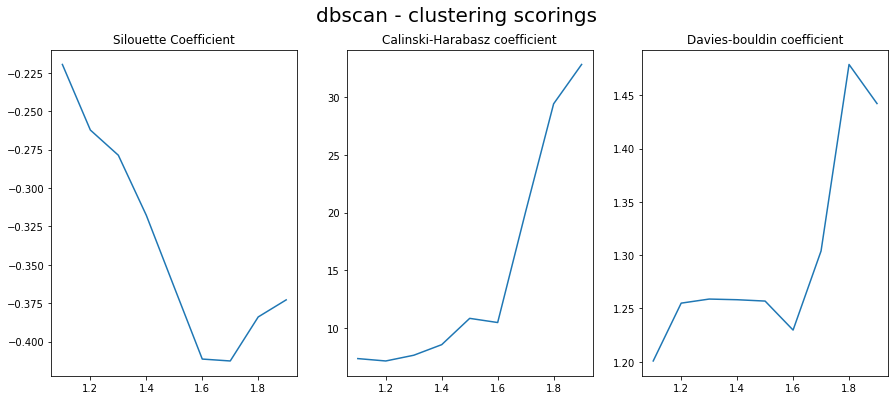

In [378]:
#@title Gaussian mixture clustering: plot clusters
#@markdown There seems to be an optimal point at eps=1.6 in the silouette coefficient.
#@markdown The davies-boulin gives a local minimum at the same point, but has a best value at eps=1.1.
#@markdown The calinski-harabasz coefficient shows a clear inflection point at eps=1.6.

key = 'dbscan'
plot_clustering_scores(scores_list, params_list, key, 'clust__eps')

In [391]:
#@title Gaussian mixture clustering: show best cluster content
#@markdown The best cluster is very selective on the top scores, only capturing 3 elements.
#@markdown DBSCAN seems to be prone to form clusters of very dissimilar sizes, not like previous methods. 

key = 'dbscan'
idx = 6
show_cluster_content(X, df_beers,labels_list[key][idx])

,beer_beerid,brewery_name,beer_style,beer_name,hmean
1793,50133,Howe Sound Inn & Brewing Company,Scottish Ale,Goodes Highland Scotch Ale,5.000000
3014,3614,Empire Brewing Company,Doppelbock,Empire Doppelbock,5.000000
298,35488,Wiltse's Brew Pub and Family Restaurant,American Stout,Wiltse's Blue Ox Stout,4.891304


##Conclusions

We explored different clustering methods in the Beer advocates dataset.
In order to tune each models hyperparameters, we explored three clustering scoring metrics. The results were not always consistent, but when lacking ground truth they allow to compare different models and hyperparameters.      